<img src="https://panel.pyviz.org/_static/logo_stacked.png" width=150 align="left" margin=20px>

The [Panel](http://panel.pyviz.org) library from [PyViz](http://pyviz.org) lets you make widget-controlled apps and dashboards from a wide variety of [plotting libraries and data types](https://github.com/pyviz/panel/issues/2).  Here let's set up four different plotting libraries controlled by a couple of widgets, for Hans Rosling's [gapminder](https://demo.bokehplots.com/apps/gapminder) example.

In [8]:
# update and/or install bokeh stack on colab
# !pip install -U bokeh hvplot panel

In [7]:
import param
import numpy as np 
import pandas as pd
import panel as pn

# load extensions into panel before importing libraries
pn.extension('vega', 'plotly')

# for colab, requires panel >= 0.10.2
# https://discourse.holoviz.org/t/using-panel-in-google-colab/251/3
pn.extension(comms='colab')

import altair as alt
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import hvplot.pandas



First, we'll get the data into a Pandas dataframe:

In [2]:
url = 'https://raw.githubusercontent.com/plotly/datasets/master/gapminderDataFiveYear.csv'
dataset = pd.read_csv(url)

In [3]:
dataset.sample(10)

,country,year,pop,continent,lifeExp,gdpPercap
323,Comoros,2007,710960.0,Africa,65.152,986.147879
74,Austria,1962,7129864.0,Europe,69.540,10750.721110
223,Cambodia,1987,8371791.0,Asia,53.914,683.895573
1535,Thailand,2007,65068149.0,Asia,70.616,7458.396327
320,Comoros,1992,454429.0,Africa,57.939,1246.907370
764,Israel,1992,4936550.0,Asia,76.930,18051.522540
598,Greece,2002,10603863.0,Europe,78.256,22514.254800
942,Malaysia,1982,14441916.0,Asia,68.000,4920.355951
18,Albania,1982,2780097.0,Europe,70.420,3630.880722
833,"Korea, Dem. Rep.",1977,16325320.0,Asia,67.159,4106.301249


Now let's define a couple of user-settable parameters (the year and whether to show a legend), then write methods to plot this data with Matplotlib, Plotly, Altair (using Vega), and hvPlot (using HoloViews and Bokeh):

In [4]:
class Gapminder(param.Parameterized):
    year = param.ObjectSelector(default=1952, objects=list(dataset.year.unique()))
    show_legend = param.Boolean(default=True)
    
    title = 'Life expectancy vs. GDP, %s'
    xlabel = 'GDP per capita (2000 dollars)'
    ylabel = 'Life expectancy (years)'
    ylim = (20, 90)
    

    def get_data(self):
        df = dataset[(dataset.year==self.year) & (dataset.gdpPercap < 10000)].copy()
        df['size'] = np.sqrt(df['pop']*2.666051223553066e-05)
        self.xlim = (df['gdpPercap'].min()-100,df['gdpPercap'].max()+1000)
        return df
    
    def mpl_view(self):
        data = self.get_data()
        title = "Matplotlib: " + (self.title % self.year)
        
        plot = plt.figure(figsize=(7, 6))
        ax = plot.add_subplot(111)
        ax.set_xscale("log")
        ax.set_title(title)
        ax.set_xlabel(self.xlabel)
        ax.set_ylabel(self.ylabel)
        ax.set_ylim(self.ylim)
        ax.set_xlim(self.xlim)

        for continent, df in data.groupby('continent'):
            ax.scatter(df.gdpPercap, y=df.lifeExp, s=df['size']*5,
                       edgecolor='black', label=continent)
            
        if self.show_legend:
            ax.legend(loc=4)
        
        plt.close(plot)
        return plot
    
    def plotly_view(self):
        data = self.get_data()
        title = 'Plotly: ' + (self.title % self.year)

        traces = []
        for continent, df in data.groupby('continent'):
            marker=dict(symbol='circle', sizemode='area', sizeref=0.1, size=df['size'], line=dict(width=2))
            traces.append(go.Scatter(x=df.gdpPercap, y=df.lifeExp, mode='markers', marker=marker, name=continent, text=df.country))
        
        axis_opts = dict(gridcolor='rgb(255, 255, 255)', zerolinewidth=1, ticklen=5, gridwidth=2)
        layout = go.Layout(title=title, showlegend=self.show_legend, width=550,
            xaxis=dict(title=self.xlabel, type='log', **axis_opts),
            yaxis=dict( title=self.ylabel, **axis_opts))
        
        return go.Figure(data=traces, layout=layout)
    
    def altair_view(self):
        data  = self.get_data()
        title = "Altair/Vega: " + (self.title % self.year)
        legend= ({} if self.show_legend else {'legend': None})

        plot  = alt.Chart(data).mark_circle().encode(
            alt.X('gdpPercap:Q', scale=alt.Scale(type='log'), axis=alt.Axis(title=self.xlabel)),
            alt.Y('lifeExp:Q', scale=alt.Scale(zero=False, domain=self.ylim), axis=alt.Axis(title=self.ylabel)),
            size=alt.Size('pop:Q', scale=alt.Scale(type="log"), legend=None),
            color=alt.Color('continent', scale=alt.Scale(scheme="category10"), **legend),
            tooltip=['continent','country'])\
            .properties(title=title).configure_axis(grid=False)
        return plot.interactive()
    
    def hvplot_view(self):
        data  = self.get_data()
        title = "hvPlot/Bokeh: " + (self.title % self.year)
        
        plot  = data.hvplot.scatter('gdpPercap', 'lifeExp', by='continent', s='size',
                  logx=True, title=title, width=500, height=400, legend=self.show_legend, hover_cols=['country'])
        plot  = plot.options(legend_position='bottom_right', xticks=[500, 1000, 2000, 5000, 10000])
        plot  = plot.redim.label(gdpPercap=self.xlabel, lifeExp=self.ylabel)
        plot  = plot.redim.range(lifeExp=self.ylim, gdpPercap=(200, 12000))
        return plot

gm = Gapminder(name='')

We can now make a panel showing the parameters of this `gm` object along with the result of calling four different `_view()` methods:

Column
    [0] Column(margin=5, width=300)
        [0] StaticText(value='<b></b>')
        [1] Select(name='Year', options=OrderedDict([('1952', ...]), value=1952)
        [2] Checkbox(name='Show legend', value=True)
    [1] Row
        [0] ParamMethod(method)
        [1] ParamMethod(method)
    [2] Row
        [0] ParamMethod(method)
        [1] ParamMethod(method)
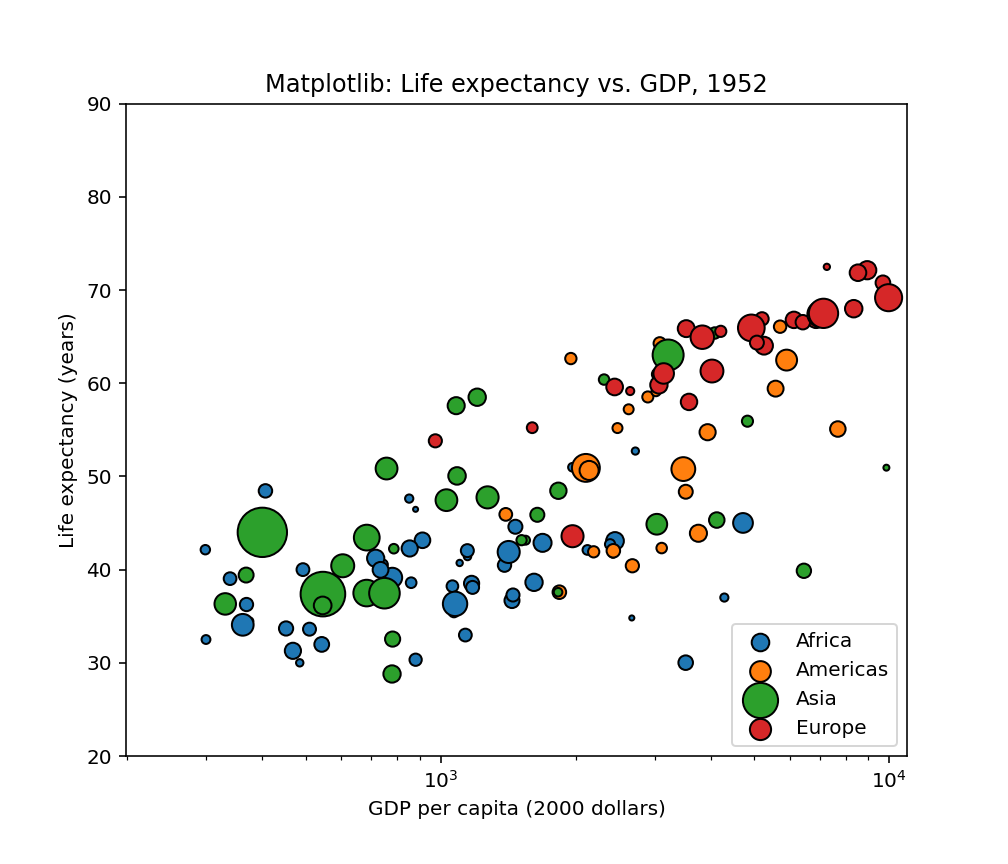

In [5]:
pn.Column(gm.param,
          pn.Row(gm.hvplot_view, gm.altair_view),
          pn.Row(gm.mpl_view,    gm.plotly_view))

Here the Matplotlib output is being rendered as PNG, but the rest are interactive, with hovering, zooming, and similar features (if allowed by the notebook viewer being used). Note that due to interactions between the various JS libraries used here, the Plotly output can get mixed up when resizing or reloading the page, but it should be reset if you adjust the year slider once you are done.

We can also make these plots available as a standalone server, if we add `.servable()` to the panel object and call this notebook as `bokeh serve --show Panel_Gapminders.ipynb`.  Before doing that, let's make another panel where we can add a logo and a title, so that it makes a nicer page layout when served separately. We'll also add an R ggplot2-based plot to fill out the page:

Row
    [0] Column
        [0] Markdown(str)
        [1] Markdown(str)
        [2] HTML(str, width=450)
        [3] Column(margin=5, width=300)
            [0] StaticText(value='<b></b>')
            [1] DiscreteSlider(formatter='%d', name='Year', options=OrderedDict([('1952', ...]), value=1952, value_throttled=1952)
            [2] Checkbox(name='Show legend', value=True)
    [1] Column
        [0] Row
            [0] ParamMethod(method)
            [1] ParamMethod(method)
        [1] Row
            [0] ParamMethod(method)
            [1] ParamMethod(method)
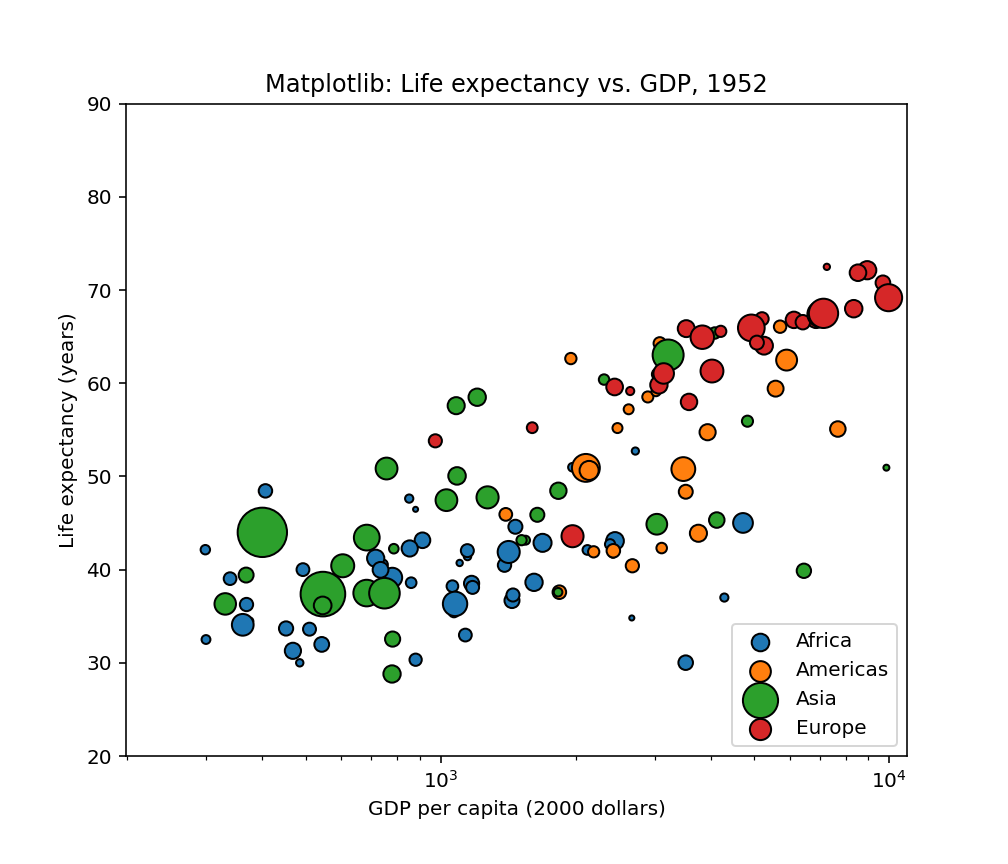

In [6]:
logo  = """<a href="http://panel.pyviz.org">
           <img src="https://panel.pyviz.org/_static/logo_stacked.png" 
            width=150 height=127 align="left" margin=20px>"""
title = '<h2>Plotting library comparison</h2>'

desc = pn.pane.HTML("""
    The <a href="http://panel.pyviz.org">Panel</a> library from <a href="http://pyviz.org">PyViz</a> 
    lets you make widget-controlled apps and dashboards from a wide variety of 
    plotting libraries and data types. Here you can try out five different plotting libraries
    controlled by a couple of widgets, for Hans Rosling's 
    <a href="https://demo.bokehplots.com/apps/gapminder">gapminder</a> example.""", width=450)

pn.Row(pn.Column(logo, title, desc, pn.panel(gm.param, widgets={'year': pn.widgets.DiscreteSlider})),
       pn.Column(pn.Row(gm.hvplot_view, gm.altair_view),
                 pn.Row(gm.mpl_view, gm.plotly_view))).servable()

Once you run Bokeh Server on this notebook, you should get a panel like the following in your web browser that you can explore or share with other users of your machine:

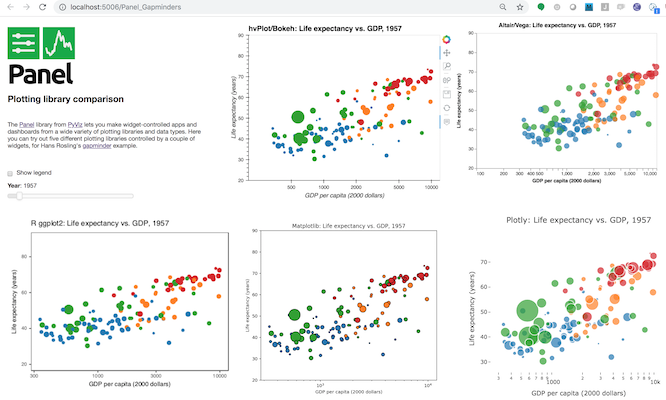